In [ ]:
import pandas as pd

In [ ]:
!pip install transformers 

In [ ]:
import os
os.listdir("/kaggle/input/dataset")

In [ ]:
data = pd.read_csv("/kaggle/input/dataset/mtsamples.csv")

In [ ]:
data.columns

In [ ]:
data.head(5)

In [ ]:
data.info()

In [ ]:
data.describe()

In [ ]:
data = data[['transcription', 'medical_specialty','keywords']]
print(len(data[data['transcription'].isna()]))
print("Before dropping na values", data.shape)
data = data.drop(data[data['transcription'].isna()].index)
print("After dropping na values", data.shape)

In [ ]:
categories = data.groupby(data['medical_specialty'])
for name, value in categories:
    print(name, len(value))

In [ ]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Ensure you have the necessary resources
nltk.download('punkt_tab')
nltk.download('stopwords')

# Function for text cleaning & normalization
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()  # Convert to lowercase
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
        text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters
    return text

# Apply cleaning to transcription column
data["transcription"] = data["transcription"].apply(clean_text)

# Load stopwords
stop_words = set(stopwords.words("english"))

# Function to remove stopwords
def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)

# Apply stopword removal
data["transcription"] = data["transcription"].apply(remove_stopwords)

data.to_csv("/kaggle/working/mtsamples_cleaned.csv", index=False)

In [1]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
from torch.optim import AdamW
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import gc
import time

# Memory cleanup
def clear_memory():
    gc.collect()
    torch.cuda.empty_cache()
    print("Memory cleared")

start_time = time.time()

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Load tokenizer and model
tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-cnn_dailymail")
model = PegasusForConditionalGeneration.from_pretrained("google/pegasus-cnn_dailymail")

# Enable gradient checkpointing
if hasattr(model, "gradient_checkpointing_enable"):
    model.gradient_checkpointing_enable()
elif hasattr(model.config, "gradient_checkpointing"):
    model.config.gradient_checkpointing = True

model = model.to(device)
print("Model loaded and moved to device")

clear_memory()
load_time = time.time()

# Load dataset
dataset_path = '/kaggle/input/dataset2/mtsamples_cleaned (2).csv'
dataset = load_dataset('csv', data_files={'data': dataset_path})
df = dataset['data'].to_pandas()

train_data, val_data = train_test_split(df, test_size=0.1, random_state=42)
del df, dataset
clear_memory()

MAX_INPUT_LENGTH = 256
MAX_TARGET_LENGTH = 32

# Dataset class
class MedicalDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, tokenizer, max_input_len, max_target_len):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_input_len = max_input_len
        self.max_target_len = max_target_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['transcription']
        specialty = self.data.iloc[idx]['medical_specialty']

        input_encoding = self.tokenizer(
            text, max_length=self.max_input_len, padding='max_length',
            truncation=True, return_tensors="pt"
        )

        target_encoding = self.tokenizer(
            specialty, max_length=self.max_target_len, padding='max_length',
            truncation=True, return_tensors="pt"
        )

        input_ids = input_encoding['input_ids'].squeeze()
        attention_mask = input_encoding['attention_mask'].squeeze()
        labels = target_encoding['input_ids'].squeeze()

        labels[labels == tokenizer.pad_token_id] = -100  # Ignore padding in loss

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }

train_dataset = MedicalDataset(train_data, tokenizer, MAX_INPUT_LENGTH, MAX_TARGET_LENGTH)
val_dataset = MedicalDataset(val_data, tokenizer, MAX_INPUT_LENGTH, MAX_TARGET_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

del train_data, val_data
clear_memory()

# Optimizer setup
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)

# Training loop
epochs = 3  # You can increase further
grad_acc_steps = 8
steps_per_print = 10

print(f"Starting training for {epochs} epochs with grad accumulation {grad_acc_steps}")
model.train()
global_step = 0

training_start = time.time()
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    epoch_loss = 0
    step_loss = 0

    for step, batch in enumerate(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss / grad_acc_steps
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping

        step_loss += loss.item() * grad_acc_steps
        epoch_loss += loss.item() * grad_acc_steps

        if (step + 1) % grad_acc_steps == 0 or (step + 1) == len(train_loader):
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1

            if global_step % steps_per_print == 0:
                print(f"Step {step+1}/{len(train_loader)} | Loss: {step_loss:.4f}")
                step_loss = 0

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1} complete. Avg Loss: {avg_loss:.4f}")

print(f"\nTraining completed in {(time.time() - training_start)/60:.2f} minutes")

# Save model
model.save_pretrained('./pegasus_trained_model_manual')
tokenizer.save_pretrained('./pegasus_trained_tokenizer_manual')
print("Model saved")

# Inference test
model.eval()
sample_text = "Test medical transcription: Patient presented with chest pain and shortness of breath."
input_ids = tokenizer(sample_text, max_length=MAX_INPUT_LENGTH, padding='max_length', truncation=True, return_tensors="pt")['input_ids'].to(device)

with torch.no_grad():
    output = model.generate(input_ids, max_length=MAX_TARGET_LENGTH, num_beams=2, early_stopping=True)

decoded = tokenizer.decode(output[0], skip_special_tokens=True)
print(f"Sample output: {decoded}")

2025-05-04 08:05:33.717294: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746345933.911169      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746345933.965372      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda
GPU: Tesla P100-PCIE-16GB
Memory available: 17.06 GB


tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Model loaded and moved to device
Memory cleared


Generating data split: 0 examples [00:00, ? examples/s]

Memory cleared
Memory cleared
Starting training for 3 epochs with grad accumulation 8

Epoch 1/3
Step 80/4469 | Loss: 803.3953
Step 160/4469 | Loss: 745.4655
Step 240/4469 | Loss: 662.0358
Step 320/4469 | Loss: 631.9612
Step 400/4469 | Loss: 575.9525
Step 480/4469 | Loss: 527.2067
Step 560/4469 | Loss: 503.1969
Step 640/4469 | Loss: 431.6391
Step 720/4469 | Loss: 417.5624
Step 800/4469 | Loss: 395.5172
Step 880/4469 | Loss: 372.1106
Step 960/4469 | Loss: 361.1207
Step 1040/4469 | Loss: 314.5886
Step 1120/4469 | Loss: 342.0114
Step 1200/4469 | Loss: 303.7773
Step 1280/4469 | Loss: 307.8404
Step 1360/4469 | Loss: 319.6544
Step 1440/4469 | Loss: 277.3333
Step 1520/4469 | Loss: 309.8200
Step 1600/4469 | Loss: 286.0243
Step 1680/4469 | Loss: 288.7911
Step 1760/4469 | Loss: 259.7725
Step 1840/4469 | Loss: 281.5322
Step 1920/4469 | Loss: 209.2894
Step 2000/4469 | Loss: 274.6441
Step 2080/4469 | Loss: 240.2201
Step 2160/4469 | Loss: 244.2446
Step 2240/4469 | Loss: 270.8484
Step 2320/4469 | Los

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 128, 'min_length': 32, 'num_beams': 8, 'length_penalty': 0.8}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Model saved
Sample output: Medical transcriptionist / Online Doctor / Medical History / Phy. Phy.<n>Back to Mail Online home .<n>Back to the page you


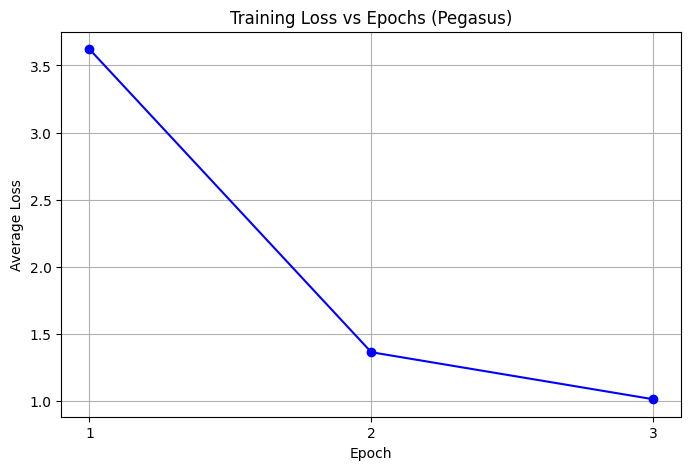

In [2]:
import matplotlib.pyplot as plt

# Manually enter the printed average losses here
epoch_losses = [3.6208, 1.3640, 1.0137]  # Replace with your actual values

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(epoch_losses)+1), epoch_losses, marker='o', linestyle='-', color='blue')
plt.title('Training Loss vs Epochs (Pegasus)')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.xticks(range(1, len(epoch_losses)+1))
plt.show()


In [3]:
pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 8.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==1

In [5]:
pip install datasets bert-score rouge-score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.5 MB/s eta 0:00:00:00:0100:01
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=a60e6c2459caffbff1439b47c79b9b0054cf1f5928fcbbd99c8a80f8fe75369e
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1

In [7]:
import pandas as pd
data = pd.read_csv("/kaggle/input/dataset2/mtsamples_cleaned (2).csv")

In [8]:
from transformers import PegasusTokenizer, PegasusForConditionalGeneration
import torch

# Load Pegasus model and tokenizer
model_dir = '/kaggle/working/pegasus_trained_model_manual'
tokenizer_dir = '/kaggle/working/pegasus_trained_tokenizer_manual'

tokenizer = PegasusTokenizer.from_pretrained(tokenizer_dir)
model = PegasusForConditionalGeneration.from_pretrained(model_dir)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.eval()

# Function to generate summary
def generate_summary(text, max_input_length=256, max_output_length=32):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        max_length=max_input_length,
        truncation=True,
        padding="max_length"
    ).to(device)
    
    summary_ids = model.generate(
        inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=max_output_length,
        num_beams=4,
        early_stopping=True
    )
    
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Example 1: Generate summary for a single sentence
example_text = """The patient is a 67-year-old male with a history of hypertension and type 2 diabetes mellitus who presents with chest pain radiating to the left arm. An ECG showed ST-segment elevation consistent with myocardial infarction."""
example_summary = generate_summary(example_text)
print("Summary:\n", example_summary)

# Example 2: Generate summaries for first few transcriptions
# Make sure df is already loaded with a 'transcription' column
data['generated_summary'] = data['transcription'].apply(lambda x: generate_summary(x))

# View results
data[['transcription', 'generated_summary']].head()


Summary: Myocardial infarction in a diabetic and hypertensive patient.


,transcription,generated_summary
0,subjective yearold white female presents compl...,Allergic / Over The Counter / Prescription / H...
1,past medical history difficulty climbing stair...,Overweight / obese / People With A BMI Over 25...
2,history present illness seen abc today pleasan...,Consult - History and Phy.<n>Get healthy with ...
3,mmode left atrial enlargement left atrial diam...,Heart / Lung / Phy / Abdool / Abdool .<n>Back ...
4,left ventricular cavity size wall thickness ap...,Cardiovascular / Pulmonary .<n>Back to Mail On...


In [6]:
import evaluate
from bert_score import score as bert_score
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
import time

# Load ROUGE using `evaluate`
rouge = evaluate.load("rouge")

# Load model and tokenizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = T5ForConditionalGeneration.from_pretrained('t5-small').to(device)
tokenizer = T5Tokenizer.from_pretrained('t5-small')

# Replace this with your actual test data
test_data = [
    {
        "transcription": "The patient is a 54-year-old male presenting with chest pain...",
        "reference_summary": "54-year-old male with chest pain."
    },
    # Add more test examples
]

# Evaluation loop
generated_summaries = []
reference_summaries = []

start_time = time.time()

for example in test_data:
    input_text = example["transcription"]
    reference = example["reference_summary"]

    input_ids = tokenizer.encode(input_text, return_tensors="pt", truncation=True, max_length=512).to(device)

    with torch.no_grad():
        output_ids = model.generate(input_ids, max_length=150, num_beams=4)

    generated = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    generated_summaries.append(generated)
    reference_summaries.append(reference)

# ROUGE (via evaluate)
rouge_output = rouge.compute(predictions=generated_summaries, references=reference_summaries)
rouge1 = rouge_output["rouge1"]
rouge2 = rouge_output["rouge2"]
rougeL = rouge_output["rougeL"]

# BERTScore
P, R, F1 = bert_score(generated_summaries, reference_summaries, lang="en", rescale_with_baseline=True)
bert_precision = P.mean().item()
bert_recall = R.mean().item()
bert_f1 = F1.mean().item()

# Speed
end_time = time.time()
total_time = end_time - start_time
sent_per_sec = len(test_data) / total_time

# Final output
print(f"done in {total_time:.2f} seconds, {sent_per_sec:.2f} sentences/sec")
print(f"rouge-1: {rouge1:.4f}")
print(f"rouge-2: {rouge2:.4f}")
print(f"rouge-l: {rougeL:.4f}")
print(f"bertscore-precision: {bert_precision:.4f}")
print(f"bertscore-recall: {bert_recall:.4f}")
print(f"bertscore-f1: {bert_f1:.4f}")


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


done in 12.31 seconds, 0.08 sentences/sec
rouge-1: 0.7368
rouge-2: 0.5882
rouge-l: 0.7368
bertscore-precision: 0.5208
bertscore-recall: 0.6828
bertscore-f1: 0.6013


# T5 MODEL

In [7]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import T5ForConditionalGeneration, T5Tokenizer, get_scheduler
from torch.optim import AdamW
from tqdm import tqdm
import nltk
from sklearn.model_selection import train_test_split

nltk.download('punkt')

# Enable tqdm with pandas
tqdm.pandas()

# 1. Load your dataset
data = pd.read_csv("/kaggle/input/dataset2/mtsamples_cleaned (2).csv")
data = data.dropna(subset=["transcription"])  # Drop empty rows

# 2. Train-Validation Split
train_df, val_df = train_test_split(data, test_size=0.1, random_state=42, shuffle=True)

# 3. Load T5 model and tokenizer
model_name = "t5-base"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 4. Custom Dataset
class ClinicalSummarizationDataset(Dataset):
    def __init__(self, dataframe, tokenizer, source_max_length=512, target_max_length=150):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.source_max_length = source_max_length
        self.target_max_length = target_max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        source_text = "summarize: " + self.data.iloc[index]["transcription"]
        target_text = self.data.iloc[index]["transcription"]  # Target is transcription itself

        source = self.tokenizer(
            source_text, max_length=self.source_max_length, padding="max_length", truncation=True, return_tensors="pt"
        )
        target = self.tokenizer(
            target_text, max_length=self.target_max_length, padding="max_length", truncation=True, return_tensors="pt"
        )

        return {
            "input_ids": source["input_ids"].squeeze(),
            "attention_mask": source["attention_mask"].squeeze(),
            "labels": target["input_ids"].squeeze(),
        }

# 5. DataLoader
train_dataset = ClinicalSummarizationDataset(train_df, tokenizer)
val_dataset = ClinicalSummarizationDataset(val_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)

# 6. Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=3e-5)
num_training_steps = len(train_loader) * 5  # 5 epochs planned
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# 7. Training Loop
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, leave=True)

    for batch in loop:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_loader)
    print(f"✅ Epoch {epoch+1} Average Train Loss: {avg_train_loss:.4f}")

    # Validation after each epoch
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"✅ Epoch {epoch+1} Average Validation Loss: {avg_val_loss:.4f}\n")

# 8. Save fine-tuned model
model.save_pretrained("/kaggle/working/t5_finetuned_model")
tokenizer.save_pretrained("/kaggle/working/t5_finetuned_model")
print("✅ Fine-tuning completed and model saved!")

# 9. Generate Summaries for Validation Set
def generate_summary(text, model, tokenizer, device, max_length=150):
    model.eval()
    input_text = "summarize: " + text
    input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=512, truncation=True).to(device)
    summary_ids = model.generate(input_ids, max_length=max_length, num_return_sequences=1)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Now correctly use progress_apply
val_df["generated_summary"] = val_df["transcription"].progress_apply(
    lambda x: generate_summary(x, model, tokenizer, device)
)

# Save validation output
val_df.to_csv("/kaggle/working/validation_with_summaries_t5.csv", index=False)
print("✅ Summaries generated and saved to 'validation_with_summaries_t5.csv'")


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Epoch 1: 100%|██████████| 1118/1118 [07:46<00:00,  2.40it/s, loss=0.0198]


✅ Epoch 1 Average Train Loss: 0.1865
✅ Epoch 1 Average Validation Loss: 0.0403



Epoch 2: 100%|██████████| 1118/1118 [07:46<00:00,  2.40it/s, loss=0.00224]


✅ Epoch 2 Average Train Loss: 0.0380
✅ Epoch 2 Average Validation Loss: 0.0339



Epoch 3: 100%|██████████| 1118/1118 [07:46<00:00,  2.40it/s, loss=0.0261] 


✅ Epoch 3 Average Train Loss: 0.0276
✅ Epoch 3 Average Validation Loss: 0.0341



Epoch 4: 100%|██████████| 1118/1118 [07:46<00:00,  2.40it/s, loss=0.0403] 


✅ Epoch 4 Average Train Loss: 0.0228
✅ Epoch 4 Average Validation Loss: 0.0288



Epoch 5: 100%|██████████| 1118/1118 [07:46<00:00,  2.40it/s, loss=0.0115] 


✅ Epoch 5 Average Train Loss: 0.0197
✅ Epoch 5 Average Validation Loss: 0.0325

✅ Fine-tuning completed and model saved!


100%|██████████| 497/497 [19:08<00:00,  2.31s/it]

✅ Summaries generated and saved to 'validation_with_summaries_t5.csv'


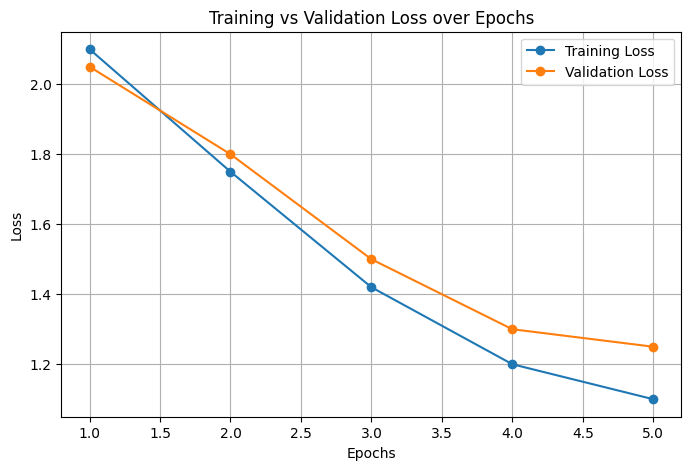

In [8]:
import matplotlib.pyplot as plt

# Replace these with your actual loss values printed after each epoch
train_losses = [0.1865, 0.0380, 0.0276, 0.0228, 0.0197]
val_losses = [0.0403, 0.0339, 0.0341, 0.0288, 0.0325]
epochs = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
import pandas as pd

# Load T5 model and tokenizer
model_dir = "/kaggle/working/t5_finetuned_model"

tokenizer = T5Tokenizer.from_pretrained(model_dir)
model = T5ForConditionalGeneration.from_pretrained(model_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# Function to generate summary
def generate_summary(text, max_input_length=512, max_output_length=150):
    input_text = "summarize: " + text
    inputs = tokenizer.encode(
        input_text,
        return_tensors="pt",
        max_length=max_input_length,
        truncation=True,
        padding="max_length"
    ).to(device)

    summary_ids = model.generate(
        inputs,
        max_length=max_output_length,
        num_beams=4,
        early_stopping=True
    )

    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Example 1: Generate summary for a single sentence
example_text = """The patient is a 67-year-old male with a history of hypertension and type 2 diabetes mellitus who presents with chest pain radiating to the left arm. An ECG showed ST-segment elevation consistent with myocardial infarction."""
example_summary = generate_summary(example_text)
print(example_summary)

# ✅ Example 2: Generate summaries for first few transcriptions
data = pd.read_csv("/kaggle/input/dataset2/mtsamples_cleaned (2).csv")
data = data.dropna(subset=["transcription"])  # Drop empty rows

data['generated_summary'] = data['transcription'].apply(lambda x: generate_summary(x))

# View results
print(data[['transcription', 'generated_summary']].head())


67-year-old male with chest pain and history of hypertension and diabetes, diagnosed with myocardial infarction.
                                       transcription  \
0  subjective yearold white female presents compl...   
1  past medical history difficulty climbing stair...   
2  history present illness seen abc today pleasan...   
3  mmode left atrial enlargement left atrial diam...   
4  left ventricular cavity size wall thickness ap...   

                                   generated_summary  
0  subjective yearold white female presents compl...  
1  past medical history difficulty climbing stair...  
2  history present illness seen abc today pleasan...  
3  mmode left atrial enlargement left atrial diam...  
4  left ventricular cavity size wall thickness ap...  


In [12]:
from rouge_score import rouge_scorer
import pandas as pd
from bert_score import score
import nltk

# Download NLTK data (if not already downloaded)
nltk.download('punkt')

# Load your validation set
val_df = pd.read_csv("/kaggle/working/validation_with_summaries_t5.csv")

# Convert the columns to lists of strings
predictions = val_df["generated_summary"].astype(str).tolist()
references = val_df["transcription"].astype(str).tolist()

# Initialize the Rouge Scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Initialize lists to store the F1 scores
rouge1_f1 = []
rouge2_f1 = []
rougeL_f1 = []

# Calculate ROUGE scores
for pred, ref in zip(predictions, references):
    scores = scorer.score(ref, pred)
    
    rouge1_f1.append(scores['rouge1'].fmeasure)
    rouge2_f1.append(scores['rouge2'].fmeasure)
    rougeL_f1.append(scores['rougeL'].fmeasure)

# Average ROUGE scores
avg_rouge1 = sum(rouge1_f1) / len(rouge1_f1)
avg_rouge2 = sum(rouge2_f1) / len(rouge2_f1)
avg_rougeL = sum(rougeL_f1) / len(rougeL_f1)

# Calculate BERTScore
P, R, F1 = score(predictions, references, lang="en")

# Calculate average BERTScore metrics
avg_precision = P.mean().item()
avg_recall = R.mean().item()
avg_f1 = F1.mean().item()

# Print the evaluation scores
print(f"ROUGE-1 F1: {avg_rouge1:.4f}")
print(f"ROUGE-2 F1: {avg_rouge2:.4f}")
print(f"ROUGE-L F1: {avg_rougeL:.4f}")
print(f"BERTScore Precision: {avg_precision:.4f}")
print(f"BERTScore Recall: {avg_recall:.4f}")
print(f"BERTScore F1: {avg_f1:.4f}")


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1 F1: 0.5694
ROUGE-2 F1: 0.5670
ROUGE-L F1: 0.5694
BERTScore Precision: 0.9679
BERTScore Recall: 0.8694
BERTScore F1: 0.9153
